In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from configs import *
import pandas as pd
from data import *
from analysis_parametric import *
from paper_figures import *
from paper_tables import *

In [3]:
save_figs = True

In [4]:
df = pd.read_pickle('data/experiment_results.pickle.xz', compression='xz')
df = process_big_df(df.copy())

In [5]:
df_sweep = process_sweep_df(df.query("hparams=='sweep'"))

In [6]:
multipliers = np.linspace(2,20,90)
df_sweep_mults = process_sweep_df(df.query("hparams=='sweep'"), trunc=multipliers)

like 67% sure we don't need to interpolate (because that's for finding minima), so straight to trying to fit power laws to the loss!

In [7]:
df

,dataset,hparams,warmup,decay,width,depth,val/loss,val/loss_std,train/loss,train/batch_time,...,params_all,flops_per_token_att_no_embed,flops_per_token_att,flops_per_token_cc,flops_per_token_no_att,flops_per_token_no_att_no_embed,flops_per_token,params,eff_params_att,train/loss_smoothed
0,rw,base,short,kaplan,1312.0,26.0,step 26 8.273299 52 7.264460 104 ...,step 26 0.001030 52 0.001519 104 ...,step 20 9.578757 40 8.079118 60 ...,step 20 1.779191 40 1.361588 60 ...,...,672079872.0,3.693920e+09,4.090921e+09,4.459618e+09,3.671753e+09,3.274752e+09,3.671753e+09,611958784.0,681820160.0,10.0 9.578757 30.0 8.079118 50.0 ...
1,rw,base,short,kaplan,832.0,21.0,step 36 7.209037 72 6.616290 144 ...,step 36 0.001431 72 0.001538 144 ...,step 20 8.892697 40 7.436884 60 ...,step 20 0.682528 40 0.471070 60 ...,...,260063232.0,1.288176e+09,1.539932e+09,1.729344e+09,1.325236e+09,1.073480e+09,1.325236e+09,220872704.0,256655360.0,10.0 8.892697 30.0 7.436884 50.0 ...
2,rw,base,short,kaplan,1024.0,23.0,step 46 7.214812 92 6.445248 184 ...,step 46 0.001484 92 0.001583 184 ...,step 20 9.301204 40 7.688476 60 ...,step 20 0.844221 40 0.625263 60 ...,...,394788864.0,2.062025e+09,2.371879e+09,2.626812e+09,2.082472e+09,1.772618e+09,2.082472e+09,347078656.0,395313152.0,10.0 9.301204 30.0 7.688476 50.0 ...
3,rw,base,short,kaplan,704.0,18.0,step 54 6.982597 107 6.311456 214 ...,step 54 0.001568 107 0.001525 214 ...,step 20 9.452538 40 7.725835 60 ...,step 20 0.499740 40 0.359278 60 ...,...,179503104.0,8.369603e+08,1.049985e+09,1.168102e+09,8.942715e+08,6.812467e+08,8.942715e+08,149045248.0,174997504.0,10.0 9.452538 30.0 7.725835 50.0 ...
4,rw,base,long,kaplan,1504.0,30.0,step 18 8.982249 36 8.261229 71 ...,step 18 0.000969 36 0.001106 71 ...,step 20 9.816062 40 8.545821 60 ...,step 20 2.452952 40 1.816782 60 ...,...,969105408.0,5.509693e+09,5.964792e+09,6.452143e+09,5.410357e+09,4.955259e+09,5.410357e+09,901726208.0,994131968.0,10.0 9.816062 30.0 8.545821 50.0 ...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
982,owt2,seed,short,const,480.0,12.0,step 3491 3.578323 6982 3.449981 13909...,step 3491 0.002134 6982 0.002143 13909...,step 20 9.114862 40 7.545253 60 ...,step 20 0.645117 40 0.569670 60 ...,...,82575360.0,2.698445e+08,4.150886e+08,4.867551e+08,3.443098e+08,1.990656e+08,3.443098e+08,57384960.0,69181440.0,10.0 9.114862 30.0 7.545253 50.0 ...
983,owt2,seed,short,const,480.0,12.0,step 3491 3.618997 6982 3.463371 13909...,step 3491 0.002187 6982 0.002132 13909...,step 20 9.093253 40 7.576393 60 ...,step 20 0.641214 40 0.574205 60 ...,...,82575360.0,2.698445e+08,4.150886e+08,4.867551e+08,3.443098e+08,1.990656e+08,3.443098e+08,57384960.0,69181440.0,10.0 9.093253 30.0 7.576393 50.0 ...
984,owt2,seed,short,const,480.0,12.0,step 3491 3.592875 6982 3.448364 13909...,step 3491 0.002187 6982 0.002127 13909...,step 20 9.114104 40 7.536318 60 ...,step 20 0.643140 40 0.571141 60 ...,...,82575360.0,2.698445e+08,4.150886e+08,4.867551e+08,3.443098e+08,1.990656e+08,3.443098e+08,57384960.0,69181440.0,10.0 9.114104 30.0 7.536318 50.0 ...
985,owt2,seed,short,const,480.0,12.0,step 1746 3.784541 3491 3.574042 5040 ...,step 1746 0.002292 3491 0.002166 5040 ...,step 20 9.106876 40 7.513043 60 ...,step 20 0.642918 40 0.571866 60 ...,...,82575360.0,2.698445e+08,4.150886e+08,4.867551e+08,3.443098e+08,1.990656e+08,3.443098e+08,57384960.0,69181440.0,10.0 9.106876 30.0 7.513043 50.0 ...


In [8]:
df.columns

Index(['dataset', 'hparams', 'warmup', 'decay', 'width', 'depth', 'val/loss',
       'val/loss_std', 'train/loss', 'train/batch_time', 'train/data_time',
       'train/lr', 'warmup_tokens', 'beta1', 'beta2', 'world_size', 'lr',
       'seed', 'seq_len', 'vocab_size', 'grad_clip_norm', 'optimizer',
       'precision', 'qk_norm', 'z_loss_coefficient', 'bs', 'independent_wd',
       'max_step', 'ckpt_path', 'params_active', 'params_active_precise',
       'params_no_embed', 'params_all', 'flops_per_token_att_no_embed',
       'flops_per_token_att', 'flops_per_token_cc', 'flops_per_token_no_att',
       'flops_per_token_no_att_no_embed', 'flops_per_token', 'params',
       'eff_params_att', 'train/loss_smoothed'],
      dtype='object')

Text(0.5, 0, 'log10(tokens)')

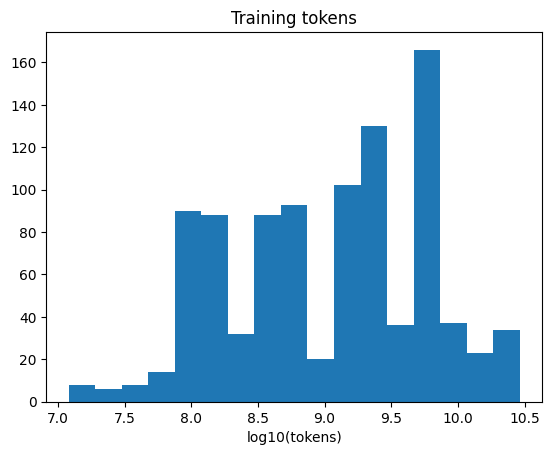

In [9]:
plt.hist(np.log10(df['val/loss'].map(lambda x: x.index[-1]) * df.bs * df.seq_len), bins=17)
plt.title('Training tokens')
plt.xlabel('log10(tokens)')

In [10]:
df['val/loss'].map(lambda x: x.iloc[-2:-1])

0      step
6650    3.202427
Name: val/loss, dtype: f...
1      step
18423    3.235371
Name: val/loss, dtype: ...
2      step
11724    3.200902
Name: val/loss, dtype: ...
3      step
27301    3.268755
Name: val/loss, dtype: ...
4      step
4513    3.267379
Name: val/loss, dtype: f...
                             ...                        
982    step
40320    3.267111
Name: val/loss, dtype: ...
983    step
45360    3.265761
Name: val/loss, dtype: ...
984    step
45360    3.265857
Name: val/loss, dtype: ...
985    step
40320    3.269968
Name: val/loss, dtype: ...
986    step
45360    3.260507
Name: val/loss, dtype: ...
Name: val/loss, Length: 975, dtype: object

In [11]:
coefs = np.array([1, 2])
exps = np.array([1, 2])
e = 0
data = np.array([np.e, np.e ** 2])
log_pred(exps, coefs, e, data)

0.7586236756795135

In [12]:
x = np.array([[1, 2], [3,4]])
np.sum(x, axis=1)

array([3, 7])

In [14]:
summary_df = perform_main_analysis(df, FIGURE1_CONFIGS)

/workspaces/resolving-scaling-law-discrepancies/analysis_parametric.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  show_df['t'] = df['val/loss'].map(lambda x: x.index[-1]) * df.bs * df.seq_len
/workspaces/resolving-scaling-law-discrepancies/analysis_parametric.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  show_df['final_loss'] = df['val/loss'].map(lambda x: x.iloc[-1])
/opt/conda/lib/python3.11/site-packages/scipy/optimize/_minimize.py:532: VisibleDeprecationWarning: Creating an ndarray from ra

ValueError: setting an array element with a sequence.